# 特征匹配

### 目标

在本章中，
- 我们将看到如何将一个图像中的特征与其他图像进行匹配。
- 我们将在OpenCV中使用Brute-Force匹配器和FLANN匹配器 

### Brute-Force匹配器的基础

蛮力匹配器很简单。它使用第一组中一个特征的描述符，并使用一些距离计算将其与第二组中的所有其他特征匹配。并返回最接近的一个。

对于BF匹配器，首先我们必须使用**cv.BFMatcher**()创建BFMatcher对象。
它需要两个可选参数。第一个是normType，它指定要使用的距离测量。默认情况下为`cv.NORM_L2`。对于SIFT，SURF等（也有`cv.NORM_L1`）很有用。
对于基于二进制字符串的描述符，例如ORB，BRIEF，BRISK等，应使用`cv.NORM_HAMMING`，该函数使用汉明距离作为度量。如果ORB使用`WTA_K == 3`或`4`，则应使用**cv.NORM_HAMMING2**。

第二个参数是布尔变量，即crossCheck，默认情况下为false。如果为true，则Matcher仅返回具有值(i，j)的那些匹配项，以使集合A中的第i个描述符具有集合B中的第j个描述符为最佳匹配，反之亦然。即两组中的两个特征应彼此匹配。它提供了一致的结果，并且是D.Lowe在SIFT论文中提出的比率测试的良好替代方案。

创建之后，两个重要的方法是*BFMatcher.match*()和*BFMatcher.knnMatch*()。第一个返回最佳匹配。第二种方法返回k个最佳匹配，其中k由用户指定。当我们需要对此做其他工作时，它可能会很有用。

就像我们使用**cv.drawKeypoints**()绘制关键点一样，**cv.drawMatches**()可以帮助我们绘制匹配项。它水平堆叠两张图像，并绘制从第一张图像到第二张图像的线，以显示最佳匹配。还有**cv.drawMatchesKnn**绘制所有k个最佳匹配。如果`k=2`，它将为每个关键点绘制两条匹配线。因此，如果要选择性地绘制，则必须通过掩码。

让我们来看一个SIFT和ORB的示例（两者都使用不同的距离测量）。

#### 使用ORB描述符进行Brute-Force匹配

在这里，我们将看到一个有关如何在两个图像之间匹配特征的简单示例。在这种情况下，我有一个queryImage和trainImage。我们将尝试使用特征匹配在trainImage中找到queryImage。（图像是/samples/data/box.png和/samples/data/box_in_scene.png）

我们正在使用ORB描述符来匹配特征。因此，让我们从加载图像，查找描述符等开始。

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('data/box.png',cv.IMREAD_GRAYSCALE)          # 索引图像
img2 = cv.imread('data/box_in_scene.png',cv.IMREAD_GRAYSCALE) # 训练图像

# 初始化ORB检测器
orb = cv.ORB_create()

# 基于ORB找到关键点和检测器
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

接下来，我们创建一个距离测量值为**cv.NORM_HAMMING**的BFMatcher对象（因为我们使用的是ORB），并且启用了CrossCheck以获得更好的结果。然后，我们使用Matcher.match()方法来获取两个图像中的最佳匹配。我们按照距离的升序对它们进行排序，以使最佳匹配（低距离）排在前面。然后我们只抽出前10的匹配（只是为了提高可见度。您可以根据需要增加它）

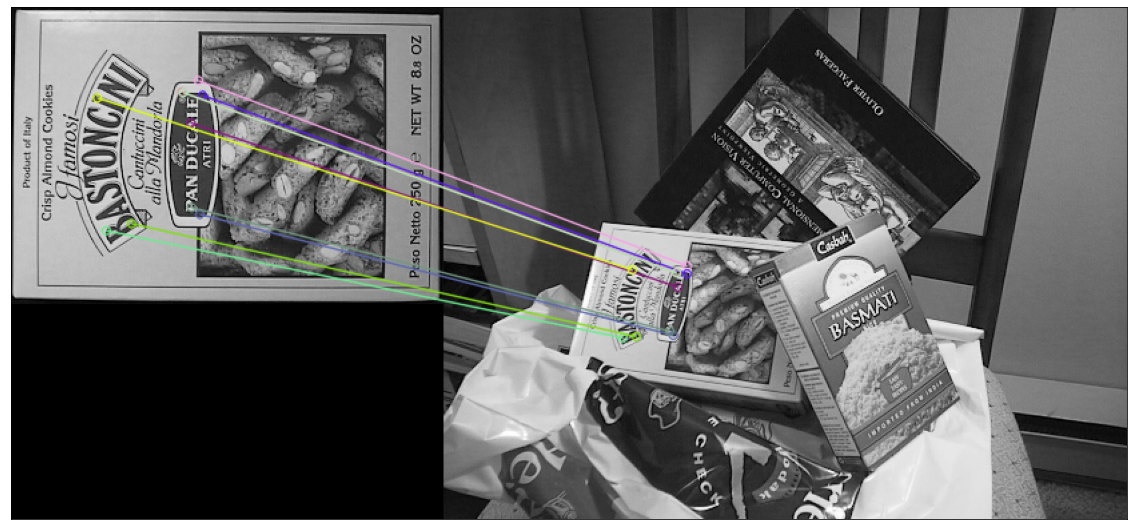

In [2]:
# 创建BF匹配器的对象
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True) # 匹配描述符.

matches = bf.match(des1,des2) # 根据距离排序
matches = sorted(matches, key = lambda x:x.distance) # 绘制前10的匹配项

img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

#### 什么是Matcher对象？
`matchs = bf.match(des1,des2)`行的结果是DMatch对象的列表。该DMatch对象具有以下属性：
- DMatch.distance-描述符之间的距离。越低越好。
- DMatch.trainIdx-训练描述符中的描述符索引
- DMatch.queryIdx-查询描述符中的描述符索引
- DMatch.imgIdx-训练图像的索引。

#### 带有SIFT描述符和比例测试的Brute-Force匹配
这次，我们将使用BFMatcher.knnMatch()获得k个最佳匹配。在此示例中，我们将k = 2，以便可以应用D.Lowe在他的论文中阐述的比例测试。

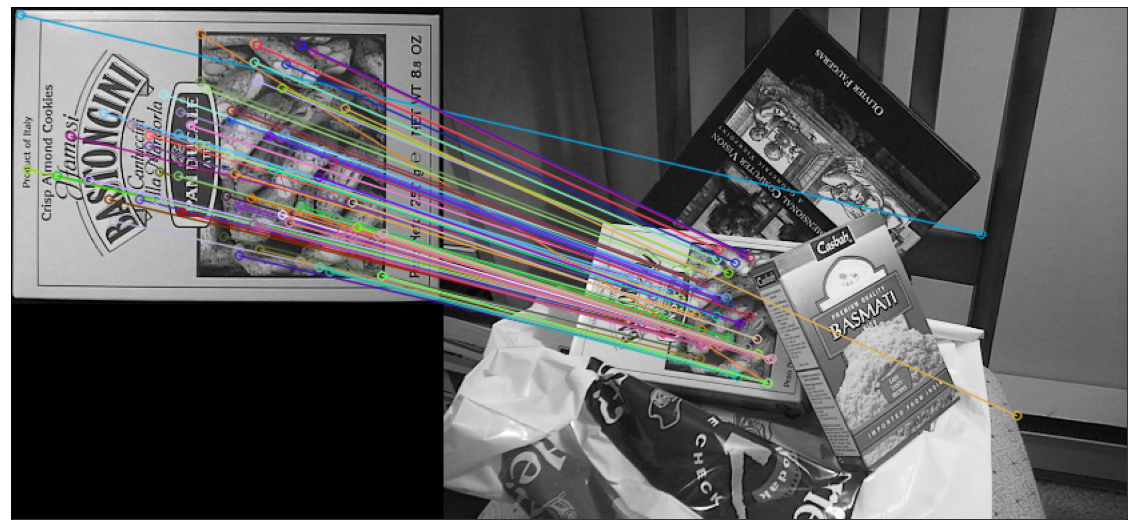

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('data/box.png',cv.IMREAD_GRAYSCALE)          # 索引图像
img2 = cv.imread('data/box_in_scene.png',cv.IMREAD_GRAYSCALE) # 训练图像

# 初始化SIFT描述符
sift = cv.xfeatures2d.SIFT_create()

# 基于SIFT找到关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# 默认参数初始化BF匹配器
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# 应用比例测试
good = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn将列表作为匹配项。
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

#### 基于匹配器的FLANN

FLANN是近似最近邻的快速库。它包含一组算法，这些算法针对大型数据集中的快速最近邻搜索和高维特征进行了优化。对于大型数据集，它的运行速度比BFMatcher快。我们将看到第二个基于FLANN的匹配器示例。

对于基于FLANN的匹配器，我们需要传递两个字典，这些字典指定要使用的算法，其相关参数等。第一个是IndexParams。对于各种算法，要传递的信息在FLANN文档中进行了说明。概括来说，对于SIFT，SURF等算法，您可以通过以下操作： 

In [4]:
FLANN_INDEX_KDTREE = 1 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

使用ORB时，你可以参考下面。根据文档建议使用带注释的值，但在某些情况下未提供必需的参数。其他值也可以正常工作。

In [5]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

第二个字典是SearchParams。它指定索引中的树应递归遍历的次数。较高的值可提供更好的精度，但也需要更多时间。如果要更改值，请传递`search_params = dict(checks = 100)`

有了这些信息，我们就很容易了。

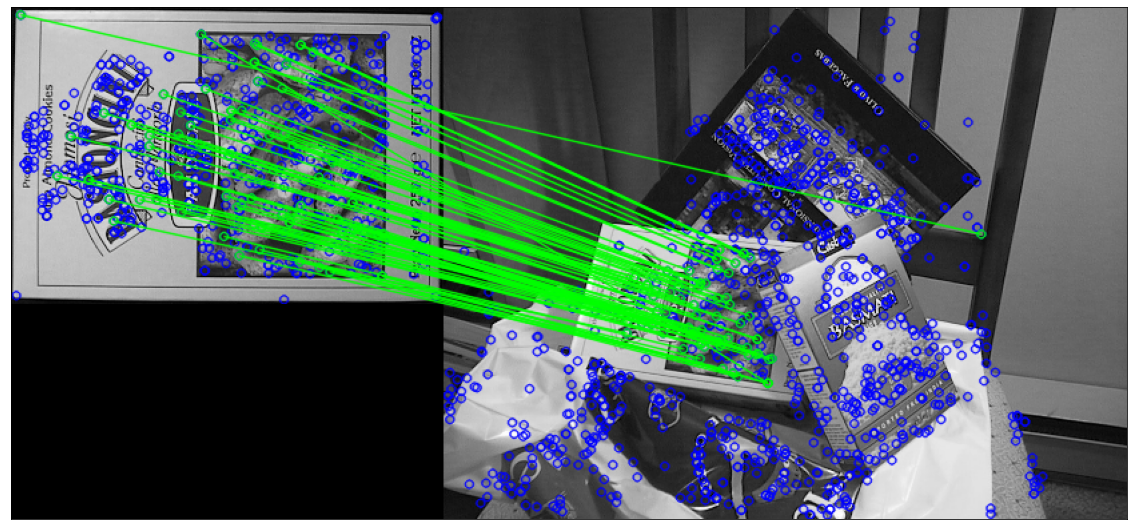

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('data/box.png',cv.IMREAD_GRAYSCALE)          # 索引图像
img2 = cv.imread('data/box_in_scene.png',cv.IMREAD_GRAYSCALE) # 训练图像

# 初始化SIFT描述符
sift = cv.xfeatures2d.SIFT_create()

# 基于SIFT找到关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN的参数
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # 或传递一个空字典
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# 只需要绘制好匹配项，因此创建一个掩码
matchesMask = [[0,0] for i in range(len(matches))]

# 根据Lowe的论文进行比例测试
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

### 附加资源

### 练习